SC1015 Project (Facial Attributes that can boost attractiveness)

In [2]:
# Load Google Drive and change directory to SC1015
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [3]:
!pip install ImageHash

     |████████████████████████████████| 812 kB 5.2 MB/s 
  Created wheel for ImageHash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295206 sha256=8dbcfd40c9ecac3aa17dbeb773e264219c6df769625c11074acf4750acd2b4ec
  Stored in directory: /root/.cache/pip/wheels/4c/d5/59/5e3e297533ddb09407769762985d134135064c6831e29a914e
Successfully built ImageHash


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
import numpy as np
from numpy import asarray
import pandas as pd

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure
import seaborn as sb
from PIL import Image
import imagehash
import hashlib
import statistics
from scipy.stats import chi2_contingency

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centered and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

In [4]:
trainData = pd.read_csv('drive/My Drive/SC1015/train.csv')
trainData.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [5]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


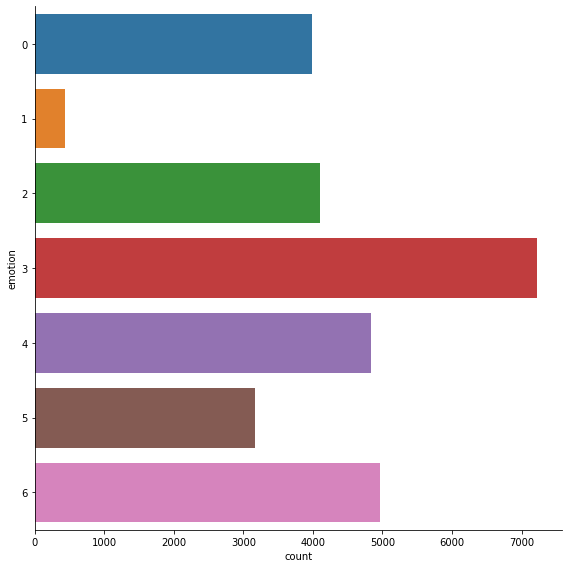

In [6]:
sb.catplot(y = "emotion", data = trainData, kind = "count", height = 8)

In [7]:
testData = pd.read_csv('drive/My Drive/SC1015/test.csv')
testData.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [8]:
testData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7178 entries, 0 to 7177
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   pixels  7178 non-null   object
dtypes: object(1)
memory usage: 56.2+ KB


Display the first 3 images

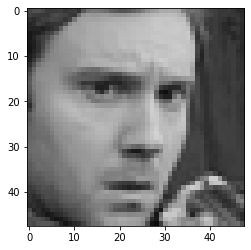

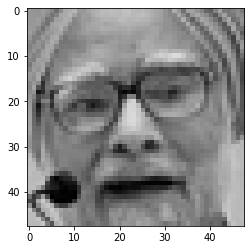

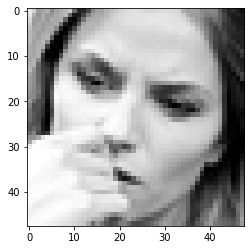

In [ ]:
for i in range(3):
  currImagePixels = trainData.iloc[i, 1]
  currImageArr = currImagePixels.split(' ')
  currImageNP = np.asarray(currImageArr, dtype=np.uint8).reshape(48,48)
  currImage = Image.fromarray(currImageNP)
  imgplot = plt.imshow(currImage, cmap='gray', vmin=0, vmax=255)
  plt.show()

Phash Analysis: Used to identify the similarity between the images

In [9]:
def getPhashFromPixels(x):
  currImageStr = x.split(' ')
  currImageNP = np.asarray(currImageStr, dtype=np.uint8).reshape(48,48)
  currImage = Image.fromarray(currImageNP)
  return imagehash.phash(currImage)

Convert the pixel column into a column with pHash

In [10]:
trainData['phash'] = trainData['pixels'].apply(getPhashFromPixels)

In [11]:
phashCount = trainData['phash'].value_counts()
phashCount = phashCount.to_frame()
phashCount

,phash
0000000000000000,11
91c8ee81f90db966,6
d49dd3f4d2843c38,6
810a1f9f9d38383f,6
c0da0b86ac6ae99f,6
...,...
f3185043bff460ce,1
97b568c66d4a7c81,1
f2fa049d8b8c6a59,1
b70868e75598b2b3,1


In [12]:
phashCount = phashCount.drop(phashCount[phashCount.phash == 1].index)
phashCount['phashUnique'] = phashCount.index
phashCount = phashCount['phashUnique'].squeeze()
phashCount

0000000000000000    0000000000000000
91c8ee81f90db966    91c8ee81f90db966
d49dd3f4d2843c38    d49dd3f4d2843c38
810a1f9f9d38383f    810a1f9f9d38383f
c0da0b86ac6ae99f    c0da0b86ac6ae99f
                          ...       
8ea97ef4aa326862    8ea97ef4aa326862
d79d0b5a39395870    d79d0b5a39395870
c6500f42f46b3cbd    c6500f42f46b3cbd
9ed6285ccb96a29a    9ed6285ccb96a29a
df980a87a1787974    df980a87a1787974
Name: phashUnique, Length: 1086, dtype: object

Why are Hash Repeating? All 0s got 11

In [ ]:
trainData.loc[trainData['phash'].astype(str) == "0000000000000000"]

,emotion,pixels,phash
6458,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0000000000000000
7629,3,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0000000000000000
10423,4,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0000000000000000
11286,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0000000000000000
13148,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0000000000000000
13402,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0000000000000000
13988,5,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0000000000000000
15894,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0000000000000000
22198,0,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0000000000000000
22927,6,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...,0000000000000000


In [ ]:
trainData.loc[trainData['phash'].astype(str) == "91c8ee81f90db966"]

,emotion,pixels,phash
6936,5,243 222 205 203 200 192 207 188 193 194 202 20...,91c8ee81f90db966
6938,2,243 222 205 203 200 192 207 188 193 194 202 20...,91c8ee81f90db966
9990,5,243 222 205 203 200 192 207 188 193 194 202 20...,91c8ee81f90db966
12243,2,243 222 205 203 200 192 207 188 193 194 202 20...,91c8ee81f90db966
12745,5,243 222 205 203 200 192 207 188 193 194 202 20...,91c8ee81f90db966
27002,5,243 222 205 203 200 192 207 188 193 194 202 20...,91c8ee81f90db966


It seems like these pixels are repeated with same phash but different emotion. We will remove all of them

In [13]:
for i in phashCount:
  trainData = trainData[trainData.phash != i]

In [14]:
trainData['phash'].value_counts()

d2d007c38e693f33    1
e899197e82f98656    1
ab0a7da5c12d3db0    1
8114e252be2fe1f3    1
c7999c923e3c3c32    1
                   ..
90b56b924d6c6dca    1
90b5279ee24b32b6    1
af74b4f28283c38b    1
cbf11fe58484da4c    1
d5ab52d5c0f4e14c    1
Name: phash, Length: 26308, dtype: int64

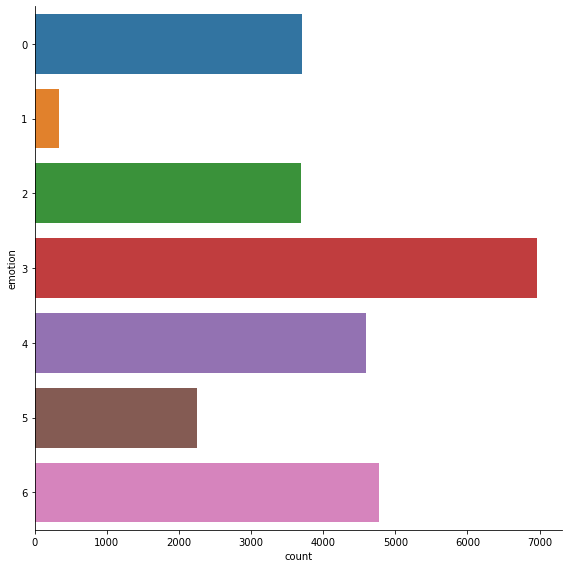

In [15]:
sb.catplot(y = "emotion", data = trainData, kind = "count", height = 8)

Find the biggest, smallest, average and median humming distance for each category. From the analysis, we can see that across the category, the median is 15, with graph skewed to the right. This means that the image are generally not similar, which is a good training set. **TODO** Can add more analysis for this portion. For model building, this is sufficient since it shows that the image is not similar

In [ ]:
def hammingDist(str1, str2):
    i = 0
    count = 0

    while(i < len(str1)):
        if(str1[i] != str2[i]):
            count += 1
        i += 1
    return count

Emotion: Angry
The Highest Distance: 16
The Lowest Distance: 2
The Mean Distance: 14.70696662387452
The Median Distance: 15.0


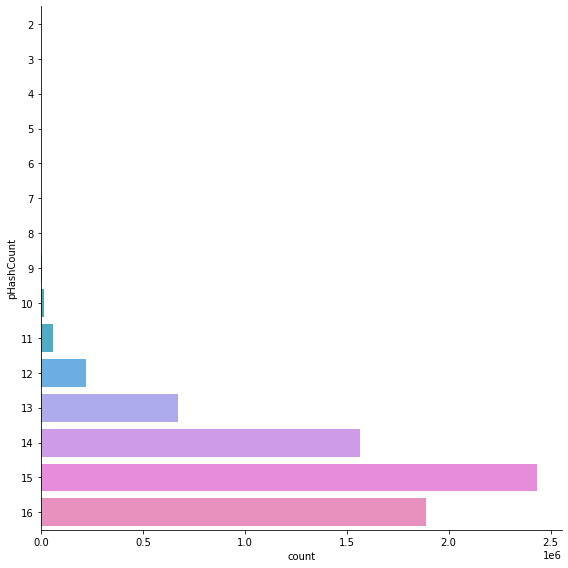


Emotion: Disgust
The Highest Distance: 16
The Lowest Distance: 2
The Mean Distance: 14.597729913307713
The Median Distance: 15


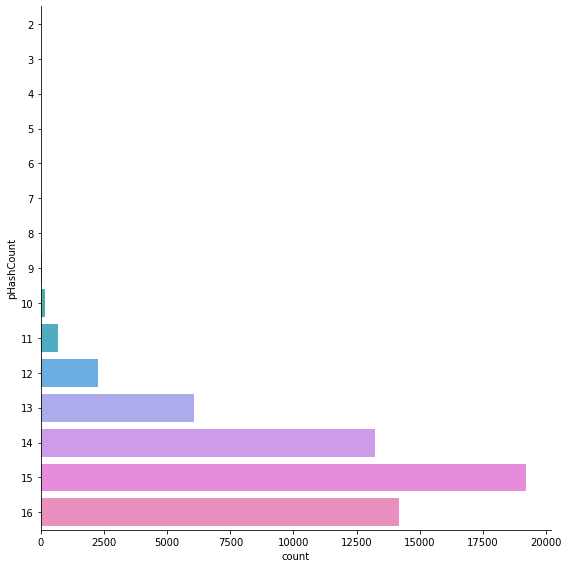


Emotion: Fear
The Highest Distance: 16
The Lowest Distance: 1
The Mean Distance: 14.710102474359324
The Median Distance: 15


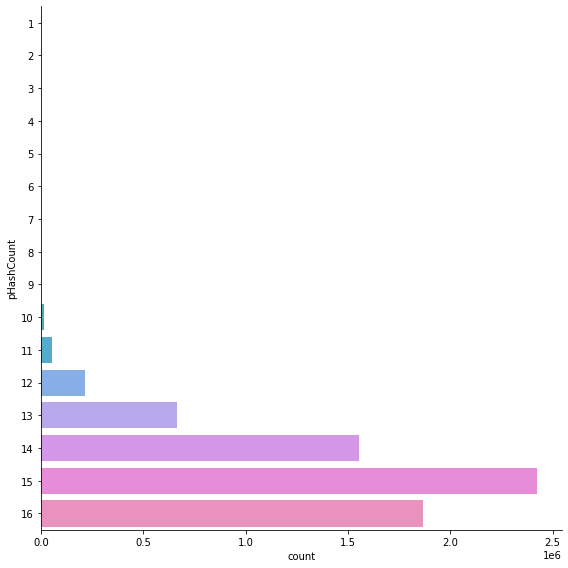


Emotion: Happy
The Highest Distance: 16
The Lowest Distance: 2
The Mean Distance: 14.635294910665806
The Median Distance: 15.0


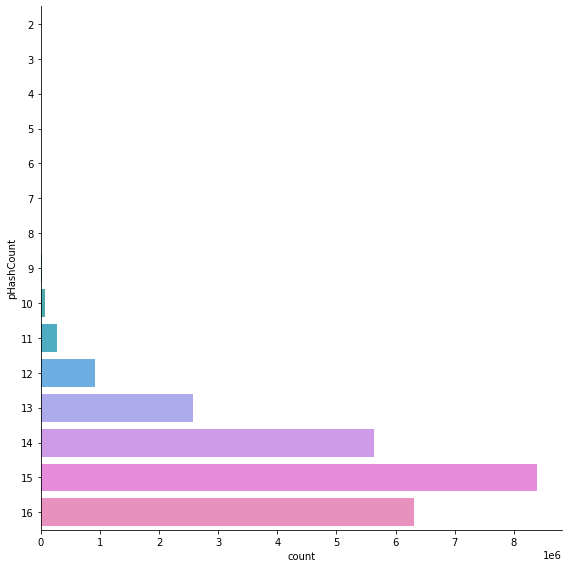


Emotion: Sad
The Highest Distance: 16
The Lowest Distance: 1
The Mean Distance: 14.727014928058747
The Median Distance: 15.0


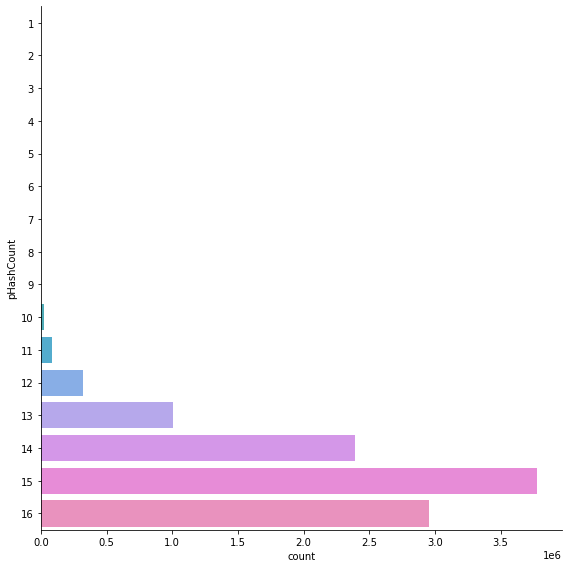


Emotion: Surprise
The Highest Distance: 16
The Lowest Distance: 1
The Mean Distance: 14.619722316768218
The Median Distance: 15


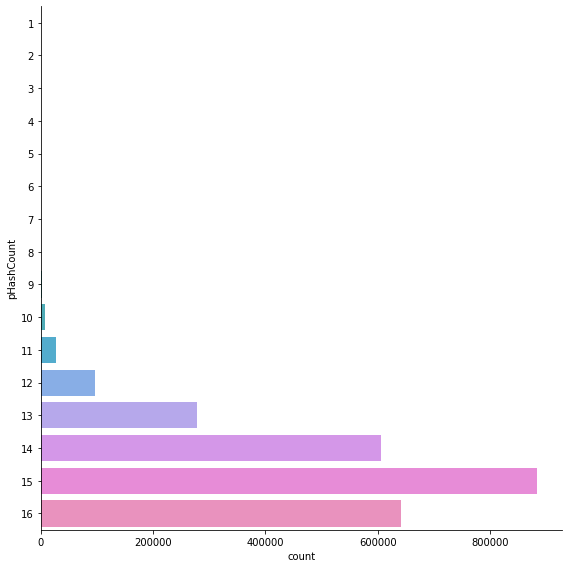


Emotion: Neutral
The Highest Distance: 16
The Lowest Distance: 2
The Mean Distance: 14.60764060124979
The Median Distance: 15


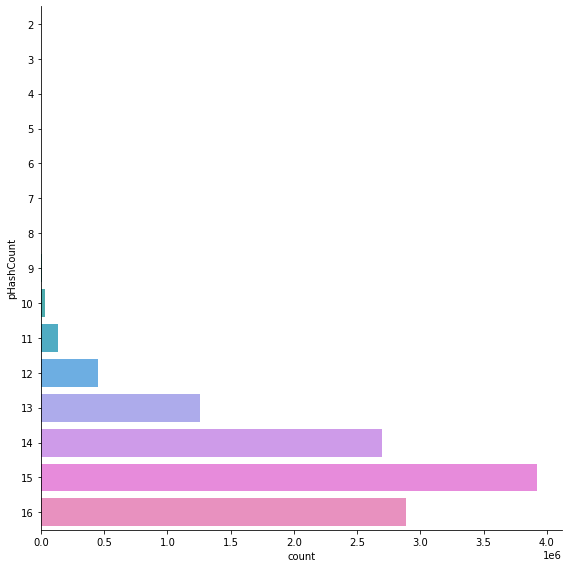

In [ ]:
for b in range(0, 7):
  emotionDataset = trainData[trainData.emotion == b]
  emotionPHash = emotionDataset['phash'].astype(str).squeeze()
  emotionPHash = emotionPHash.tolist()
  emotionPHashAnalysis = []

  for i in range(0, len(emotionPHash)):
    for a in range(i+1, len(emotionPHash)):
      emotionPHashAnalysis.append(hammingDist(emotionPHash[i], emotionPHash[a]))
  
  if(b == 0):
    print("Emotion: Angry")
  elif (b == 1):
    print("Emotion: Disgust")
  elif (b == 2):
    print("Emotion: Fear")
  elif (b == 3):
    print("Emotion: Happy")
  elif (b == 4):
    print("Emotion: Sad")
  elif (b == 5):
    print("Emotion: Surprise")
  elif (b == 6):
    print("Emotion: Neutral")
  print("The Highest Distance: " + str(max(emotionPHashAnalysis)))
  print("The Lowest Distance: " + str(min(emotionPHashAnalysis)))
  print("The Mean Distance: " + str(statistics.mean(emotionPHashAnalysis)))
  print("The Median Distance: " + str(statistics.median(emotionPHashAnalysis)))
  emotionPHashAnalysis = pd.Series(emotionPHashAnalysis, name="pHashCount")
  emotionPHashAnalysis = emotionPHashAnalysis.to_frame()
  sb.catplot(y = "pHashCount", data = emotionPHashAnalysis, kind = "count", height = 8)
  plt.show()
  print("")

Facial Expression Recognition (FER) dataset. This dataset is given in train.csv and test.csv. For consistent terminology, during training, train.csv will be split into train + evaluation. Test.csv will be used to evaluated the model

Image Normalization. It improves the learning speed of Neural Networks and provides regularization, avoiding overfitting. Output Range [0,1] so we divide each pixel by 255

In [15]:
trainPixels = []
for currImagePixels in trainData['pixels']:
  currImageArr = currImagePixels.split(' ')
  # Convert input into an array, reshape it into 48 by 48 (Size of the image)
  currImageNP = np.asarray(currImageArr, dtype=np.uint8).reshape(48,48)
  currImageNP = currImageNP/255
  trainPixels.append(currImageNP)

X_data = np.array(trainPixels)
X_data

array([[[0.2745098 , 0.31372549, 0.32156863, ..., 0.20392157,
         0.16862745, 0.16078431],
        [0.25490196, 0.23921569, 0.22745098, ..., 0.21960784,
         0.20392157, 0.17254902],
        [0.19607843, 0.16862745, 0.21176471, ..., 0.19215686,
         0.21960784, 0.18431373],
        ...,
        [0.35686275, 0.25490196, 0.16470588, ..., 0.28235294,
         0.21960784, 0.16862745],
        [0.30196078, 0.32156863, 0.30980392, ..., 0.41176471,
         0.2745098 , 0.18039216],
        [0.30196078, 0.28235294, 0.32941176, ..., 0.41568627,
         0.42745098, 0.32156863]],

       [[0.59215686, 0.58823529, 0.57647059, ..., 0.50588235,
         0.54901961, 0.47058824],
        [0.59215686, 0.58431373, 0.58431373, ..., 0.47843137,
         0.55294118, 0.5372549 ],
        [0.59215686, 0.59215686, 0.61176471, ..., 0.42745098,
         0.48235294, 0.57254902],
        ...,
        [0.7372549 , 0.7372549 , 0.4745098 , ..., 0.7254902 ,
         0.7254902 , 0.72941176],
        [0.7

In [16]:
Y_data = trainData['emotion'].values
Y_data

array([0, 0, 2, ..., 4, 0, 4])

In [17]:
#Hyperparameter

in_channels = 1
numClasses = 7
learningRate = 0.0001
batchSize = 64
numEpoch = 20

# Change to GPU if available
#device = torch.device('cpu')
device = torch.device('cuda')

In [42]:
X_train, X_val, Y_train, Y_val = train_test_split(X_data, Y_data, test_size=0.3)

In [43]:
X_trainT = torch.from_numpy(X_train.astype(np.float32))
X_valT = torch.from_numpy(X_val.astype(np.float32))
y_trainT = torch.from_numpy(Y_train.astype(np.int_))
y_valT = torch.from_numpy(Y_val.astype(np.int_))

X_trainT = X_trainT.unsqueeze(1)
X_valT = X_valT.unsqueeze(1)

trainDataset = TensorDataset(X_trainT,y_trainT)
trainLoader = DataLoader(trainDataset, batch_size = batchSize, shuffle = True)
valDataset = TensorDataset(X_valT, y_valT)
valLoader = DataLoader(valDataset, batch_size = batchSize, shuffle = True)

In [20]:
def train(epoch, trainLoader):
  trainLoss = 0.00
  for batch_idx, (data, targets) in enumerate(trainLoader):
    data = data.to(device=device)
    targets = targets.to(device=device)
    model.train()

    #forward
    scores = model(data)
    loss = criterion(scores, targets)

    #backward
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    trainLoss += loss.item()
  print("Epoch: %d Training Loss: %.5f" % (epoch, (trainLoss/len(data))))
  return trainLoss/len(data)

In [21]:
def validationLoss(epoch, valLoader):
  validLoss = 0.0
  model.eval()     # Optional when not using Model Specific layer
  for data, labels in valLoader:
      data = data.to(device=device)
      labels = labels.to(device=device)
      
      target = model(data)
      loss = criterion(target,labels)
      validLoss = loss.item() * data.size(0)

  print("Epoch: %d Validation Loss: %.5f" % (epoch, (validLoss/len(data))))
  return validLoss/len(data)

In [22]:
def checkAccuracy(loader, model):
  numCorrect = 0
  numSamples = 0
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device=device)
      y = y.to(device=device)

      scores = model(x)
      _,preds = scores.max(1)
      numCorrect += (preds == y).sum()
      numSamples += preds.size(0)
    
    accuracy = float(numCorrect)/ float(numSamples)*100
    print("Accuracy: %.5f" % accuracy)

Experiment 1: Shallow CNN. We will experiment with 2 Convolutional Layer + 1 Fully Connected Layer.

In [ ]:
# For Version 1, let's start with 2 convolutional Layers + 1 Fully Connected Layer
# Shallow CNN
class CNNV1(Module):   
    def __init__(self, in_channels, numClasses):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size = (3,3), stride = (1,1), padding = (1,1))
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride = (2,2))
        self.conv2 = nn.Conv2d(8, 16, kernel_size = (3,3), stride = (1,1), padding = (1,1))
        self.fc1 = nn.Linear(16 * 12 * 12, numClasses)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        return x

In [ ]:
model = CNNV1(in_channels, numClasses)
if torch.cuda.is_available():
    model.cuda()
optimizer = Adam(model.parameters(), learningRate)
criterion = CrossEntropyLoss()

In [ ]:
totalTrainLoss = []
totalValLoss = []
for epoch in range(numEpoch):
  totalTrainLoss.append(train(epoch, trainLoader))
  totalValLoss.append(validationLoss(epoch, valLoader))

Epoch: 0 Training Loss: 11.76029
Epoch: 0 Validation Loss: 1.89381
Epoch: 1 Training Loss: 11.68241
Epoch: 1 Validation Loss: 1.96770
Epoch: 2 Training Loss: 11.64528
Epoch: 2 Validation Loss: 1.88131
Epoch: 3 Training Loss: 11.61528
Epoch: 3 Validation Loss: 1.94442
Epoch: 4 Training Loss: 11.55527
Epoch: 4 Validation Loss: 1.97786
Epoch: 5 Training Loss: 11.51442
Epoch: 5 Validation Loss: 1.88729
Epoch: 6 Training Loss: 11.48117
Epoch: 6 Validation Loss: 1.90331
Epoch: 7 Training Loss: 11.45909
Epoch: 7 Validation Loss: 1.86970
Epoch: 8 Training Loss: 11.44085
Epoch: 8 Validation Loss: 1.94752
Epoch: 9 Training Loss: 11.42616
Epoch: 9 Validation Loss: 1.84890
Epoch: 10 Training Loss: 11.41075
Epoch: 10 Validation Loss: 1.96719
Epoch: 11 Training Loss: 11.39758
Epoch: 11 Validation Loss: 1.78139
Epoch: 12 Training Loss: 11.38638
Epoch: 12 Validation Loss: 1.72284
Epoch: 13 Training Loss: 11.37253
Epoch: 13 Validation Loss: 1.89335
Epoch: 14 Training Loss: 11.36336
Epoch: 14 Validation

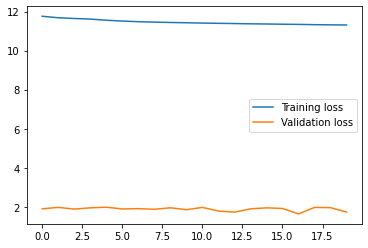

In [ ]:
plt.plot(totalTrainLoss, label='Training loss')
plt.plot(totalValLoss, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
checkAccuracy(trainLoader, model)
checkAccuracy(valLoader, model)

Accuracy: 25.24470
Accuracy: 23.71722


Experiment 1 Verdict: We can see that this model is very bad. The training Loss and Validation Loss stays stagnent. We can also see the accuracy at around 25%, far from ideal.

Experiment 2: For version 2, we will start building a model with more connected Layers, 

In [123]:
# For Version 2, we will build a deep CNN.
# Deep CNN
class CNNV2(Module):   
    def __init__(self, in_channels, numClasses):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size = (5,5), stride = (1,1), padding = (1,1))
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size = (5,5), stride = (1,1), padding = (1,1))
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride = (2,2))
        self.dropout1 = torch.nn.Dropout(p=0.4)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = (3,3), stride = (1,1), padding = (1,1))
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size = (3,3), stride = (1,1), padding = (1,1))
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride = (2,2))
        self.dropout2 = torch.nn.Dropout(p=0.4)
        self.conv5 = nn.Conv2d(128, 256, kernel_size = (3,3), stride = (1,1), padding = (1,1))
        self.batchnorm5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 256, kernel_size = (3,3), stride = (1,1), padding = (1,1))
        self.batchnorm6 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2), stride = (2,2))
        self.dropout3 = torch.nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(256 * 5 * 5, 128)
        self.batchnorm7 = nn.BatchNorm2d(256)
        self.dropout4 = torch.nn.Dropout(p=0.6)
        self.fc2 = nn.Linear(128, numClasses)
        

    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout1(self.pool1(x))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        x = self.batchnorm4(F.relu(self.conv4(x)))
        x = self.dropout2(self.pool2(x))
        x = self.batchnorm5(F.relu(self.conv5(x)))
        x = self.batchnorm6(F.relu(self.conv6(x)))
        x = self.dropout3(self.pool3(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

In [124]:
model = CNNV2(in_channels, numClasses)
if torch.cuda.is_available():
    model.cuda()
optimizer = Adam(model.parameters(), learningRate)
criterion = CrossEntropyLoss()

In [110]:
totalTrainLoss = []
totalValLoss = []
for epoch in range(numEpoch):
  totalTrainLoss.append(train(epoch, trainLoader))
  totalValLoss.append(validationLoss(epoch, valLoader))

Epoch: 0 Training Loss: 10.49802
Epoch: 0 Validation Loss: 1.68037
Epoch: 1 Training Loss: 9.37580
Epoch: 1 Validation Loss: 1.43175
Epoch: 2 Training Loss: 8.72455
Epoch: 2 Validation Loss: 1.82789
Epoch: 3 Training Loss: 8.22060
Epoch: 3 Validation Loss: 1.26084
Epoch: 4 Training Loss: 7.79218
Epoch: 4 Validation Loss: 1.38063
Epoch: 5 Training Loss: 7.44204
Epoch: 5 Validation Loss: 0.96283
Epoch: 6 Training Loss: 7.18582
Epoch: 6 Validation Loss: 1.10994
Epoch: 7 Training Loss: 6.89663
Epoch: 7 Validation Loss: 0.88277
Epoch: 8 Training Loss: 6.65178
Epoch: 8 Validation Loss: 1.15237
Epoch: 9 Training Loss: 6.42486
Epoch: 9 Validation Loss: 1.00023
Epoch: 10 Training Loss: 6.20480
Epoch: 10 Validation Loss: 1.28034
Epoch: 11 Training Loss: 6.00669
Epoch: 11 Validation Loss: 0.87231
Epoch: 12 Training Loss: 5.76141
Epoch: 12 Validation Loss: 0.87291
Epoch: 13 Training Loss: 5.52567
Epoch: 13 Validation Loss: 1.28676
Epoch: 14 Training Loss: 5.35779
Epoch: 14 Validation Loss: 1.01084

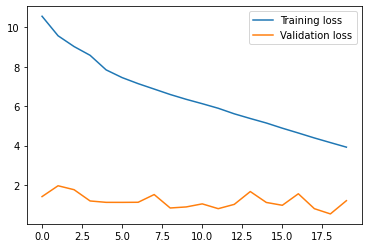

In [ ]:
plt.plot(totalTrainLoss, label='Training loss')
plt.plot(totalValLoss, label='Validation loss')
plt.legend()
plt.show()

In [ ]:
checkAccuracy(trainLoader, model)
checkAccuracy(valLoader, model)

Accuracy: 86.47249
Accuracy: 58.91296


Experiment 3: Looking at experiment 2, the accuracy has significantly increased. However, this model is showing signs of overfitting since the training accuracy is 99% but the validation accuracy is 60%. This could be due to the lack of data. In order to mitigate this issue, we will try Stratified K-Fold

Epoch: 0 Training Loss: 34.58148
Epoch: 0 Validation Loss: 1.77206
Epoch: 1 Training Loss: 31.84073
Epoch: 1 Validation Loss: 1.76631
Epoch: 2 Training Loss: 30.14279
Epoch: 2 Validation Loss: 1.65417
Epoch: 3 Training Loss: 28.72804
Epoch: 3 Validation Loss: 1.54777
Epoch: 4 Training Loss: 27.77098
Epoch: 4 Validation Loss: 1.28901
Epoch: 5 Training Loss: 26.96315
Epoch: 5 Validation Loss: 1.63087
Epoch: 6 Training Loss: 25.92705
Epoch: 6 Validation Loss: 1.51520
Epoch: 7 Training Loss: 25.22107
Epoch: 7 Validation Loss: 1.16153
Epoch: 8 Training Loss: 24.46995
Epoch: 8 Validation Loss: 1.44835
Epoch: 9 Training Loss: 23.55797
Epoch: 9 Validation Loss: 1.53233
Epoch: 10 Training Loss: 21.38423
Epoch: 10 Validation Loss: 1.30915
Epoch: 11 Training Loss: 20.33239
Epoch: 11 Validation Loss: 1.35433
Epoch: 12 Training Loss: 19.34954
Epoch: 12 Validation Loss: 1.32143
Epoch: 13 Training Loss: 18.53483
Epoch: 13 Validation Loss: 1.26289
Epoch: 14 Training Loss: 17.81065
Epoch: 14 Validation

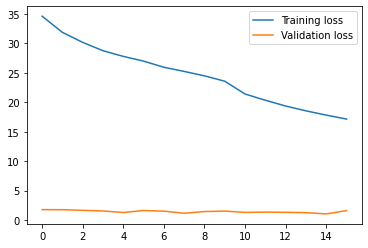

Epoch: 0 Training Loss: 18.19505
Epoch: 0 Validation Loss: 0.82621
Epoch: 1 Training Loss: 17.28696
Epoch: 1 Validation Loss: 0.70442
Epoch: 2 Training Loss: 16.24791
Epoch: 2 Validation Loss: 0.44950
Epoch: 3 Training Loss: 15.61127
Epoch: 3 Validation Loss: 0.98104
Epoch: 4 Training Loss: 14.70177
Epoch: 4 Validation Loss: 0.92060
Epoch: 5 Training Loss: 13.99600
Epoch: 5 Validation Loss: 0.76650
Epoch: 6 Training Loss: 13.24275
Epoch: 6 Validation Loss: 0.77401
Epoch: 7 Training Loss: 12.38682
Epoch: 7 Validation Loss: 0.86279
Epoch: 8 Training Loss: 11.53758
Epoch: 8 Validation Loss: 0.78493
Epoch: 9 Training Loss: 10.89532
Epoch: 9 Validation Loss: 0.61338
Epoch: 10 Training Loss: 10.06054
Epoch: 10 Validation Loss: 0.71201
Epoch: 11 Training Loss: 9.57806
Epoch: 11 Validation Loss: 1.15884
Epoch: 12 Training Loss: 8.83655
Epoch: 12 Validation Loss: 1.43707
Epoch: 13 Training Loss: 8.23531
Epoch: 13 Validation Loss: 1.43912
Epoch: 14 Training Loss: 7.85923
Epoch: 14 Validation Los

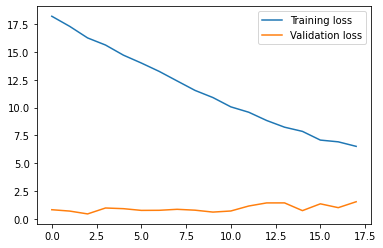

Epoch: 0 Training Loss: 10.77545
Epoch: 0 Validation Loss: 0.10065
Epoch: 1 Training Loss: 9.32140
Epoch: 1 Validation Loss: 0.10625
Epoch: 2 Training Loss: 8.45752
Epoch: 2 Validation Loss: 0.22591
Epoch: 3 Training Loss: 7.74560
Epoch: 3 Validation Loss: 0.23484
Epoch: 4 Training Loss: 7.05109
Epoch: 4 Validation Loss: 0.28833
Epoch: 5 Training Loss: 6.47790
Epoch: 5 Validation Loss: 0.11461
Epoch: 6 Training Loss: 6.03917
Epoch: 6 Validation Loss: 0.27133
Epoch: 7 Training Loss: 5.42392
Epoch: 7 Validation Loss: 0.23145
Epoch: 8 Training Loss: 5.26610
Epoch: 8 Validation Loss: 0.29066
Epoch: 9 Training Loss: 4.91146
Epoch: 9 Validation Loss: 0.20338
Epoch: 10 Training Loss: 4.72806
Epoch: 10 Validation Loss: 0.43493
Epoch: 11 Training Loss: 4.39300
Epoch: 11 Validation Loss: 0.23931
Epoch: 12 Training Loss: 4.10908
Epoch: 12 Validation Loss: 0.52470
Epoch: 13 Training Loss: 3.94412
Epoch: 13 Validation Loss: 0.36860
Epoch: 14 Training Loss: 3.70957
Epoch: 14 Validation Loss: 0.46585

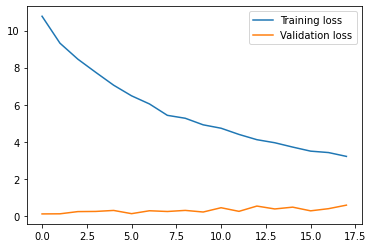

Epoch: 0 Training Loss: 5.83885
Epoch: 0 Validation Loss: 0.14811
Epoch: 1 Training Loss: 4.88578
Epoch: 1 Validation Loss: 0.02390
Epoch: 2 Training Loss: 4.16150
Epoch: 2 Validation Loss: 0.03023
Epoch: 3 Training Loss: 3.84321
Epoch: 3 Validation Loss: 0.06965
Epoch: 4 Training Loss: 3.59781
Epoch: 4 Validation Loss: 0.09475
Epoch: 5 Training Loss: 3.23388
Epoch: 5 Validation Loss: 0.01648
Epoch: 6 Training Loss: 3.19596
Epoch: 6 Validation Loss: 0.05331
Epoch: 7 Training Loss: 3.06378
Epoch: 7 Validation Loss: 0.10401
Epoch: 8 Training Loss: 3.04590
Epoch: 8 Validation Loss: 0.11801
Epoch: 9 Training Loss: 2.85078
Epoch: 9 Validation Loss: 0.08797
Epoch: 10 Training Loss: 2.69600
Epoch: 10 Validation Loss: 0.04573
Epoch: 11 Training Loss: 2.71371
Epoch: 11 Validation Loss: 0.28364
Epoch: 12 Training Loss: 2.51994
Epoch: 12 Validation Loss: 0.08359
Epoch: 13 Training Loss: 2.48747
Epoch: 13 Validation Loss: 0.15101
Epoch: 14 Training Loss: 2.29257
Epoch: 14 Validation Loss: 0.07433


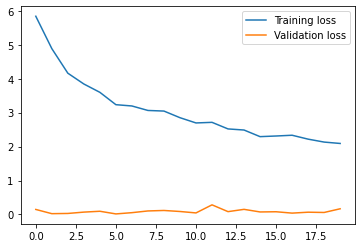

Epoch: 0 Training Loss: 3.68853
Epoch: 0 Validation Loss: 0.06078
Epoch: 1 Training Loss: 3.39448
Epoch: 1 Validation Loss: 0.00707
Epoch: 2 Training Loss: 2.88945
Epoch: 2 Validation Loss: 0.01880
Epoch: 3 Training Loss: 2.59458
Epoch: 3 Validation Loss: 0.06083
Epoch: 4 Training Loss: 2.46244
Epoch: 4 Validation Loss: 0.11513
Epoch: 5 Training Loss: 2.43024
Epoch: 5 Validation Loss: 0.01596
Epoch: 6 Training Loss: 2.23130
Epoch: 6 Validation Loss: 0.01649
Epoch: 7 Training Loss: 2.20180
Epoch: 7 Validation Loss: 0.06386
Epoch: 8 Training Loss: 2.20038
Epoch: 8 Validation Loss: 0.02055
Epoch: 9 Training Loss: 2.12890
Epoch: 9 Validation Loss: 0.05878
Epoch: 10 Training Loss: 1.99523
Epoch: 10 Validation Loss: 0.01431
Epoch: 11 Training Loss: 1.93983
Epoch: 11 Validation Loss: 0.07860
Epoch: 12 Training Loss: 1.92154
Epoch: 12 Validation Loss: 0.08563
Epoch: 13 Training Loss: 1.72789
Epoch: 13 Validation Loss: 0.11506
Epoch: 14 Training Loss: 1.92380
Epoch: 14 Validation Loss: 0.02328


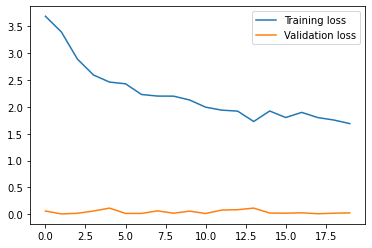

In [111]:
skf = StratifiedKFold(n_splits=5)
model = CNNV2(in_channels, numClasses)
if torch.cuda.is_available():
    model.cuda()
optimizer = Adam(model.parameters(), learningRate)
criterion = CrossEntropyLoss()
for train_index, test_index in skf.split(X_train, Y_train):
  X_trainKF, X_valKF = X_train[train_index], X_train[test_index]
  y_trainKF, y_valKF = Y_train[train_index], Y_train[test_index]

  X_trainKF = torch.from_numpy(X_trainKF.astype(np.float32))
  X_valKF = torch.from_numpy(X_valKF.astype(np.float32))
  y_trainKF = torch.from_numpy(y_trainKF.astype(np.int_))
  y_valKF = torch.from_numpy(y_valKF.astype(np.int_))

  X_trainKF = X_trainKF.unsqueeze(1)
  X_valKF = X_valKF.unsqueeze(1)

  trainKFDataset = TensorDataset(X_trainKF,y_trainKF)
  trainLoaderKF = DataLoader(trainKFDataset, batch_size = batchSize, shuffle = True)
  valKFDataset = TensorDataset(X_valKF, y_valKF)
  valLoaderKF = DataLoader(valKFDataset, batch_size = batchSize, shuffle = True)

  totalTrainLoss = []
  totalValLoss = []

  for epoch in range(numEpoch):
    totalTrainLoss.append(train(epoch, trainLoaderKF))
    totalValLoss.append(validationLoss(epoch, valLoaderKF))
  
    if(len(totalValLoss) > 15):
      if(totalValLoss[-1] > totalValLoss[-2] and totalValLoss[-1] > totalValLoss[-3] and totalValLoss[-1] > totalValLoss[-4] and totalValLoss[-1] > totalValLoss[-5] and totalValLoss[-1] > totalValLoss[-6]):
        print("Stoppage Triggered")
        break
  plt.plot(totalTrainLoss, label='Training loss')
  plt.plot(totalValLoss, label='Validation loss')
  plt.legend()
  plt.show()
    
    
  



In [115]:
checkAccuracy(trainLoader, model)
checkAccuracy(valLoader, model)

Accuracy: 98.90307
Accuracy: 58.03877


Experiment 4: The TA has recommended a solution to resolve the overfitting issue of the model, and that is to reduce the complexity of the model.

In [44]:
# For Version 3, we will edit version 2 of the CNN to make changes. Reduce the amount of Convolution Layers to 4
# Deep CNN
class CNNV3(Module):   
    def __init__(self, in_channels, numClasses):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size = (5,5), stride = (1,1), padding = (1,1))
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size = (5,5), stride = (1,1), padding = (1,1))
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride = (2,2))
        self.dropout1 = torch.nn.Dropout(p=0.4)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = (3,3), stride = (1,1), padding = (1,1))
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size = (3,3), stride = (1,1), padding = (1,1))
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride = (2,2))
        self.dropout2 = torch.nn.Dropout(p=0.4)
        self.conv5 = nn.Conv2d(128, 256, kernel_size = (3,3), stride = (1,1), padding = (1,1))
        self.batchnorm5 = nn.BatchNorm2d(256)
        self.dropout3 = torch.nn.Dropout(p=0.5)
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2), stride = (2,2))
        self.fc1 = nn.Linear(128 * 11 * 11, numClasses)
        self.batchnorm7 = nn.BatchNorm2d(256)
        self.dropout4 = torch.nn.Dropout(p=0.6)
        

    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout1(self.pool1(x))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        x = self.batchnorm4(F.relu(self.conv4(x)))
        x = self.dropout2(self.pool2(x))
        x = torch.flatten(x, 1)
        #print(x.view(64,-1).shape)
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        return x

In [45]:
model = CNNV3(in_channels, numClasses)
if torch.cuda.is_available():
    model.cuda()
optimizer = Adam(model.parameters(), learningRate)
criterion = CrossEntropyLoss()

In [61]:
totalTrainLoss = []
totalValLoss = []
for epoch in range(numEpoch):
  totalTrainLoss.append(train(epoch, trainLoader))
  totalValLoss.append(validationLoss(epoch, valLoader))

Epoch: 0 Training Loss: 6.41505
Epoch: 0 Validation Loss: 1.81951
Epoch: 1 Training Loss: 6.43170
Epoch: 1 Validation Loss: 1.95843
Epoch: 2 Training Loss: 6.36298
Epoch: 2 Validation Loss: 2.47051
Epoch: 3 Training Loss: 6.26830
Epoch: 3 Validation Loss: 2.18635
Epoch: 4 Training Loss: 6.17232
Epoch: 4 Validation Loss: 1.35384
Epoch: 5 Training Loss: 6.08850
Epoch: 5 Validation Loss: 2.03262
Epoch: 6 Training Loss: 6.04078
Epoch: 6 Validation Loss: 1.28819
Epoch: 7 Training Loss: 6.01996
Epoch: 7 Validation Loss: 2.73874
Epoch: 8 Training Loss: 5.94138
Epoch: 8 Validation Loss: 1.67181
Epoch: 9 Training Loss: 5.84793
Epoch: 9 Validation Loss: 0.98686
Epoch: 10 Training Loss: 5.83081
Epoch: 10 Validation Loss: 2.29088
Epoch: 11 Training Loss: 5.77257
Epoch: 11 Validation Loss: 1.28270
Epoch: 12 Training Loss: 5.67682
Epoch: 12 Validation Loss: 1.41581
Epoch: 13 Training Loss: 5.65716
Epoch: 13 Validation Loss: 1.48418
Epoch: 14 Training Loss: 5.52888
Epoch: 14 Validation Loss: 1.05765


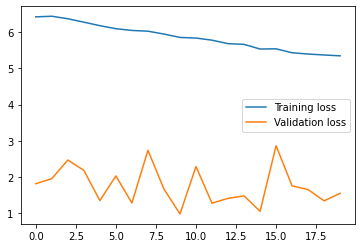

In [62]:
plt.plot(totalTrainLoss, label='Training loss')
plt.plot(totalValLoss, label='Validation loss')
plt.legend()
plt.show()

In [63]:
checkAccuracy(trainLoader, model)
checkAccuracy(valLoader, model)

Accuracy: 70.43714
Accuracy: 45.39465


In [67]:
torch.save(model, 'drive/My Drive/SC1015/model.pth')

Part 2: CelebA dataset. Load CelebA data into Jupyter. CelebA dataset consists of 30,000 celebrities images with 40 labels, consisting of their facial features. Originally, CelebA attributes are given in a txt format. We need to convert the txt file into CSV using a Python script on our laptop.

In [45]:
celebAData = pd.read_csv('drive/My Drive/SC1015/CelebAMask-HQ-attribute-anno.csv')
celebAData.head()

,img,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,0.jpg,-1,1,1,1,-1,-1,1,-1,-1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
1,1.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
2,2.jpg,-1,-1,1,1,-1,-1,1,-1,-1,...,-1,1,-1,1,1,-1,1,-1,-1,1
3,3.jpg,-1,-1,1,-1,-1,-1,-1,1,1,...,-1,1,-1,1,-1,-1,1,-1,-1,1
4,4.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,1,-1,1,-1,-1,-1,-1,1


In [31]:
model = torch.load('drive/My Drive/SC1015/model.pth')
model.eval()

CNNV3(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.4, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batchnorm4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.4, inplace=False)
  (conv5): Conv2d

In [73]:
predictedEmotion = []
pathToImg = 'drive/My Drive/SC1015/CelebA-HQ-img/'
rescale = transforms.Compose([transforms.Resize((48,48))])
transform = transforms.ToTensor()
imageList = celebAData['img']
for x in imageList:
  print("Image: " + x)
  currentDirectory = pathToImg + x
  currentImg = Image.open(currentDirectory).convert('L')
  currentImg = rescale(currentImg)
  currentImg = transform(currentImg)
  currentImg = currentImg/255
  currentImg = currentImg.unsqueeze(0).to(device=device)
  output = model(currentImg)
  
  _,preds = output.topk(k=1)
  predictedEmotion.append(preds.item())
  
print("Done!")


Streaming output truncated to the last 5000 lines.
Image: 25001.jpg
Image: 25002.jpg
Image: 25003.jpg
Image: 25004.jpg
Image: 25005.jpg
Image: 25006.jpg
Image: 25007.jpg
Image: 25008.jpg
Image: 25009.jpg
Image: 25010.jpg
Image: 25011.jpg
Image: 25012.jpg
Image: 25013.jpg
Image: 25014.jpg
Image: 25015.jpg
Image: 25016.jpg
Image: 25017.jpg
Image: 25018.jpg
Image: 25019.jpg
Image: 25020.jpg
Image: 25021.jpg
Image: 25022.jpg
Image: 25023.jpg
Image: 25024.jpg
Image: 25025.jpg
Image: 25026.jpg
Image: 25027.jpg
Image: 25028.jpg
Image: 25029.jpg
Image: 25030.jpg
Image: 25031.jpg
Image: 25032.jpg
Image: 25033.jpg
Image: 25034.jpg
Image: 25035.jpg
Image: 25036.jpg
Image: 25037.jpg
Image: 25038.jpg
Image: 25039.jpg
Image: 25040.jpg
Image: 25041.jpg
Image: 25042.jpg
Image: 25043.jpg
Image: 25044.jpg
Image: 25045.jpg
Image: 25046.jpg
Image: 25047.jpg
Image: 25048.jpg
Image: 25049.jpg
Image: 25050.jpg
Image: 25051.jpg
Image: 25052.jpg
Image: 25053.jpg
Image: 25054.jpg
Image: 25055.jpg
Image: 25056.j

In [76]:
celebAData['predictedEmotion'] = predictedEmotion
celebAData.head()

,img,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,predictedEmotion
0,0.jpg,-1,1,1,1,-1,-1,1,-1,-1,...,1,-1,1,-1,-1,1,-1,-1,1,3
1,1.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,1,-1,1,-1,-1,1,-1,-1,1,0
2,2.jpg,-1,-1,1,1,-1,-1,1,-1,-1,...,1,-1,1,1,-1,1,-1,-1,1,0
3,3.jpg,-1,-1,1,-1,-1,-1,-1,1,1,...,1,-1,1,-1,-1,1,-1,-1,1,0
4,4.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,1,-1,1,-1,-1,-1,-1,1,0


In [77]:
celebAData.to_csv('drive/My Drive/SC1015/predictedCelebA.csv')

Part 3: Data Driven Insights

In [18]:
predictedCelebA = pd.read_csv('drive/My Drive/SC1015/predictedCelebA.csv')
predictedCelebA.head()

,img,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,predictedEmotion
0,0.jpg,-1,1,1,1,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,1,3
1,1.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,1,0
2,2.jpg,-1,-1,1,1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,1,1,-1,1,-1,-1,1,0
3,3.jpg,-1,-1,1,-1,-1,-1,-1,1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,1,-1,-1,1,0
4,4.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,1,-1,1,-1,-1,-1,-1,1,0


In [19]:
predictedCelebA = predictedCelebA.replace(-1, 0)
predictedCelebA.head()

,img,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,predictedEmotion
0,0.jpg,0,1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,3
1,1.jpg,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0
2,2.jpg,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,1,0
3,3.jpg,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0
4,4.jpg,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0


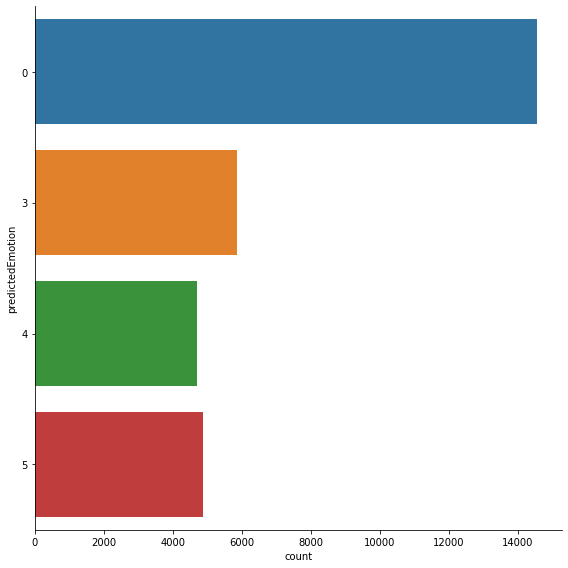

In [20]:
sb.catplot(y = "predictedEmotion", data = predictedCelebA, kind = "count", height = 8)

To simplify the categorization, split the Emotion into 2 types, Positive (1) and Negative(0). Positive Emotion will consists of Happy and Surprise. Negative Emotion will consists of Angry and Sad. This is consistant with the research paper.

In [24]:
predictedCelebA.loc[predictedCelebA['predictedEmotion'] == 4, 'predictedEmotion'] = 0
predictedCelebA.loc[predictedCelebA['predictedEmotion'] == 3, 'predictedEmotion'] = 1
predictedCelebA.loc[predictedCelebA['predictedEmotion'] == 5, 'predictedEmotion'] = 1

predictedCelebA

,img,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,predictedEmotion
0,0.jpg,0,1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,1
1,1.jpg,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0
2,2.jpg,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,1,0
3,3.jpg,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0
4,4.jpg,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29995.jpg,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
29996,29996.jpg,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,1
29997,29997.jpg,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
29998,29998.jpg,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1


In [25]:
categoricalVariables = predictedCelebA.drop(columns=['img', '5_o_Clock_Shadow'])
categoricalVariables

,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,predictedEmotion
0,1,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,1
1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0
2,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,1,0
3,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0
4,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
29996,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,1
29997,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
29998,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1


In [26]:
def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [27]:
rows= []

for var1 in categoricalVariables:
  col = []
  for var2 in categoricalVariables :
    cramers =cramers_V(categoricalVariables[var1], categoricalVariables[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
cramersOutput = pd.DataFrame(cramers_results, columns = categoricalVariables.columns, index =categoricalVariables.columns)
pd.set_option('display.max_columns', None)

cramersOutput

,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,Blurry,Brown_Hair,Bushy_Eyebrows,Chubby,Double_Chin,Eyeglasses,Goatee,Gray_Hair,Heavy_Makeup,High_Cheekbones,Male,Mouth_Slightly_Open,Mustache,Narrow_Eyes,No_Beard,Oval_Face,Pale_Skin,Pointy_Nose,Receding_Hairline,Rosy_Cheeks,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,predictedEmotion
Arched_Eyebrows,1.00,0.06,0.03,0.01,0.00,0.03,0.02,0.00,0.02,0.00,0.00,0.00,0.02,0.01,0.03,0.03,0.01,0.24,0.05,0.21,0.01,0.02,0.00,0.08,0.00,0.00,0.02,0.00,0.06,0.03,0.02,0.00,0.04,0.12,0.01,0.24,0.04,0.03,0.03,0.0
Attractive,0.06,1.00,0.06,0.03,0.00,0.01,0.12,0.00,0.03,0.00,0.01,0.00,0.09,0.07,0.05,0.03,0.05,0.19,0.01,0.17,0.00,0.03,0.01,0.05,0.02,0.01,0.04,0.04,0.02,0.02,0.01,0.00,0.04,0.01,0.01,0.19,0.01,0.03,0.19,0.0
Bags_Under_Eyes,0.03,0.06,1.00,0.02,0.01,0.00,0.15,0.00,0.02,0.00,0.00,0.01,0.03,0.05,0.00,0.02,0.03,0.14,0.01,0.16,0.00,0.02,0.01,0.05,0.02,0.00,0.02,0.02,0.02,0.02,0.02,0.00,0.02,0.02,0.00,0.14,0.01,0.05,0.08,0.0
Bald,0.01,0.03,0.02,1.00,0.01,0.00,0.03,0.01,0.00,0.00,0.01,0.00,0.07,0.06,0.02,0.02,0.04,0.02,0.00,0.04,0.00,0.02,0.00,0.02,0.00,0.00,0.00,0.03,0.00,0.01,0.00,0.01,0.01,0.01,0.00,0.03,0.00,0.03,0.05,0.0
Bangs,0.00,0.00,0.01,0.01,1.00,0.00,0.01,0.00,0.01,0.00,0.00,0.01,0.01,0.01,0.00,0.01,0.00,0.01,0.00,0.02,0.00,0.01,0.00,0.03,0.00,0.00,0.00,0.02,0.00,0.01,0.00,0.00,0.00,0.00,0.01,0.02,0.01,0.01,0.00,0.0
Big_Lips,0.03,0.01,0.00,0.00,0.00,1.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.03,0.01,0.03,0.01,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.02,0.02,0.00,0.04,0.01,0.01,0.02,0.0
Big_Nose,0.02,0.12,0.15,0.03,0.01,0.00,1.00,0.02,0.04,0.00,0.03,0.02,0.10,0.09,0.03,0.05,0.04,0.12,0.00,0.21,0.01,0.05,0.01,0.09,0.01,0.01,0.03,0.05,0.01,0.03,0.02,0.00,0.02,0.01,0.01,0.16,0.00,0.05,0.10,0.0
Black_Hair,0.00,0.00,0.00,0.01,0.00,0.01,0.02,1.00,0.06,0.00,0.07,0.08,0.00,0.00,0.00,0.01,0.01,0.01,0.00,0.02,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.01,0.01,0.00,0.00,0.01,0.0
Blond_Hair,0.02,0.03,0.02,0.00,0.01,0.00,0.04,0.06,1.00,0.00,0.05,0.04,0.01,0.01,0.01,0.02,0.00,0.06,0.02,0.09,0.01,0.01,0.00,0.04,0.00,0.00,0.01,0.01,0.02,0.02,0.01,0.00,0.01,0.01,0.01,0.09,0.03,0.01,0.00,0.0
Blurry,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.99,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0


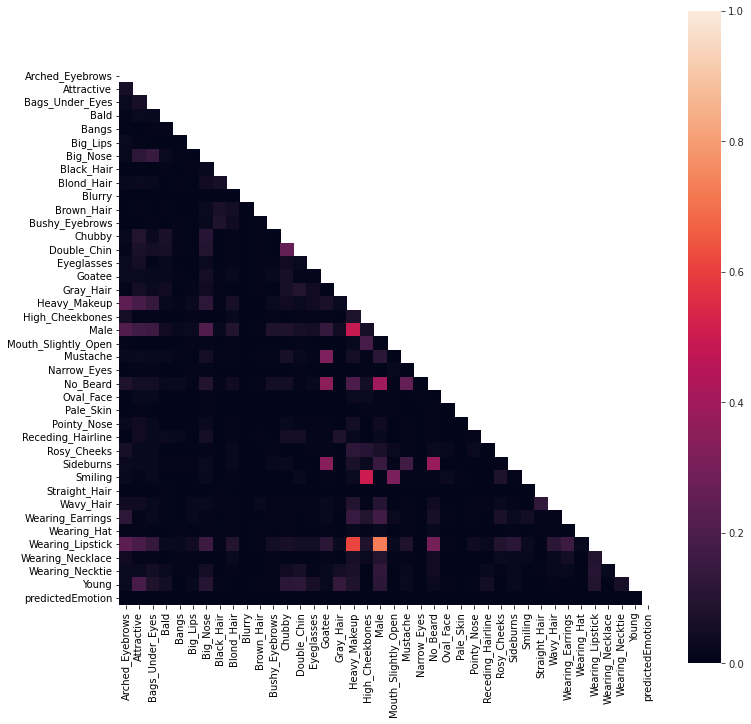

In [17]:
mask = np.zeros_like(cramersOutput, dtype=bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(12,12)) 
with sb.axes_style("white"):
  ax = sb.heatmap(cramersOutput, mask=mask,vmin=0., vmax=1, square=True, ax=ax)

plt.show()